### Collision Detection using Grover's Algorithm

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plot

We now define generalised function for Oracle $O_f^\pm$ and Diffusion $D$ circuit generators for any arbitrary bit string of length $n$ and solution key $solution$.

In [2]:
def OracleCircuit(n,solution):

    qc = QuantumCircuit(n)

    for qubit_index, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit_index)

    qc.h(n-1)

    qc.mcx(list(range(n-1)),n-1)

    qc.h(n-1)

    for qubit_index, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit_index)

    oracle_gate = qc.to_gate()

    oracle_gate.name = "Oracle"

    return oracle_gate


In [3]:
def GroverDiffuser(n):
    qc = QuantumCircuit(n)

    qc.h(range(n))

    qc.x(range(n))

    qc.h(n-1)

    qc.mcx(list(range(n-1)),n-1) #Toffoli gate

    qc.h(n-1)

    qc.x(range(n))

    qc.h(range(n))

    diff_gate = qc.to_gate()

    diff_gate.name = "Diffuser"

    return diff_gate

We now define our number of qubits and the *key solution* for our collision detection.

In [4]:
n = 3
N = 2**n 
solution = '101'

Initialise our circuit and create the Grover search circuit:

In [5]:
qc = QuantumCircuit(n,n) #n qubits and a classical register of n bits for measurement results. 

Instead of using the typical iteration calculation:

$$ r \approx \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor $$

I'll use a more accurate calculation of:

$$r \approx \frac{\pi}{4 \sin^{-1}(\frac{1}{\sqrt{N}})} - \frac{1}{2}$$

Which is derived from analysis of the rotation of state vector in $2-D$ plane spanned by *key* basis vector and *$\psi$ - key* basis vector.

In [6]:
import math

iter = round(((math.pi)/(4*math.asin(1/math.sqrt(N)))) - 0.5)

print("Number of Grover iterations required are: ", iter)

Number of Grover iterations required are:  2


Lets now generate the entire circuit:

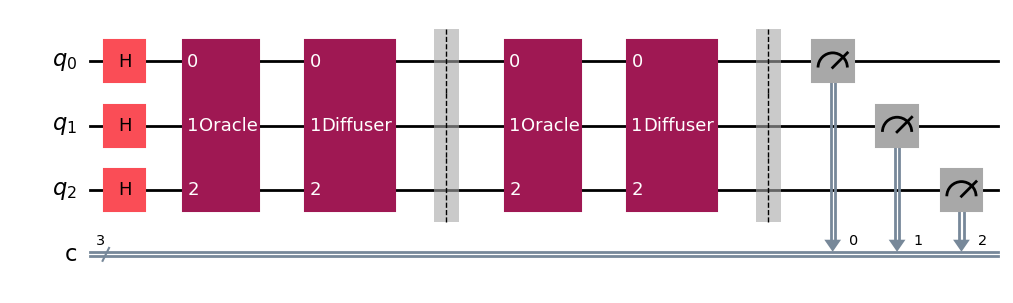

In [7]:
qc.h(range(n)) #apply hadamard gate on all qubits to create a complete equal superposition of all possible 2**n states.

oracle_circ = OracleCircuit(n,solution=solution)
diff_circ = GroverDiffuser(n)

for i in range(iter):
    qc.append(oracle_circ,range(n))
    qc.append(diff_circ, range(n))
    qc.barrier(range(n))

qc.measure(range(n),range(n));

qc.draw('mpl')

#### Intutition behind Oracle and Diffuser:

The simplest oracle function is one which takes in an input $x$ and spits out $f(x)$ where $f:\{0,1\}^n \xrightarrow[]{} \{0,1\}$ is our oracle function. To convert this to a implemntable circuit, we take $n$ input qubits for a $n$ bit binary digit $x$ and spit out $f(x)$. To make this circuit unitary, we implement a special circuit $O_f^\pm$ which flips the target basis vector and does nothing to all other basis vectors. Such an implementation is implementable with a unitary, reversiable quantum circuit.

The diffuser is a circuit tasked with increasing the probability amplitude of the target solution basis vector once it has been flipped by the oracle. For a large bitstring $n$, the average of all amplitudes after oracle has acted, $\mu$ will be greater than $0$. This ensures $\mu - \alpha > \mu - \beta$ where $\alpha$ is the amplitude of the target basis vector *after* flipping and $\beta$ is the amplitude of other non-target basis vectors. This condition ensures that if the diffuser flips all amplitudes about $\mu$, then the ampltude of target basis vector will *increase*. This will only occur untill $\mu > 0$ and hence we have to calculate an optimal number of iterations.

{'110': 27, '100': 19, '010': 11, '000': 22, '001': 15, '011': 10, '111': 12, '101': 1932}


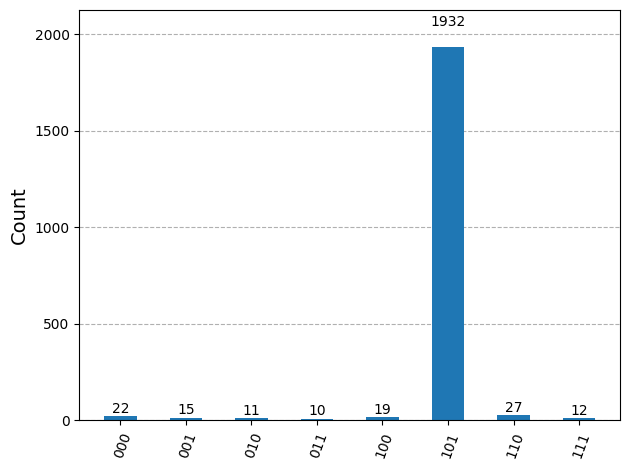

In [8]:
from qiskit import transpile

backend = AerSimulator()
shots = 2048

transpiled_qc = transpile(qc,backend)

job = backend.run(transpiled_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_qc)

print(counts)

plot_histogram(counts)

Above is a simulation of the circuit using the AerSimulator package. We can see that over 2048 runs, the most probable result observed is our solution of 101.

We will now scale to $n=4$ and draw a plot depecting the amplitude evolution over multiple iterations.

Number of Grover iterations required are:  3


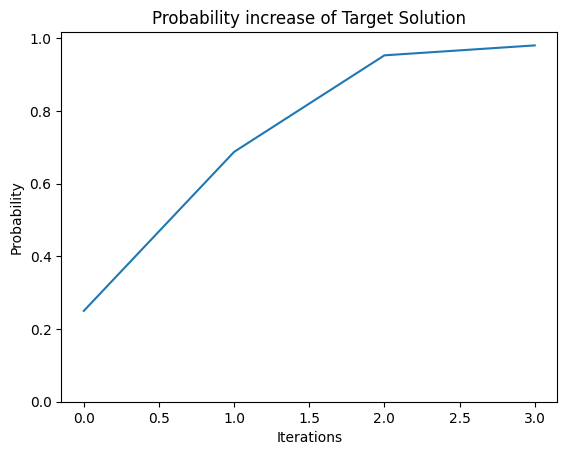

[0.24999999999999992, 0.6874999999999986, 0.9531249999999966, 0.980468749999995]


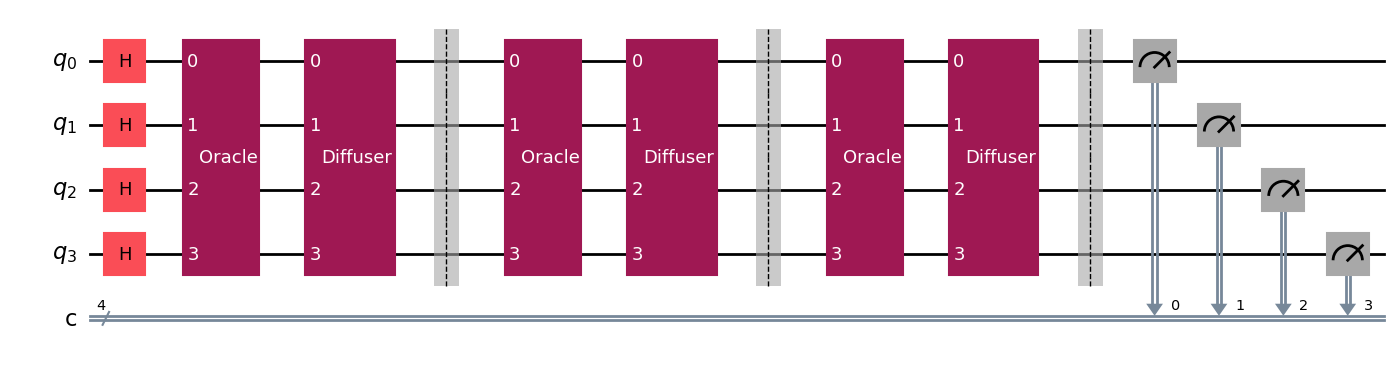

In [9]:
n = 4
N = 2**n 
solution = '1001'

from qiskit.quantum_info import Statevector #for visualisation of amplitude evolution
amplitudes = []

solution_index = int(solution,2)

qc = QuantumCircuit(n,n)

iter = round(((math.pi)/(4*math.asin(1/math.sqrt(N)))) - 0.5)

print("Number of Grover iterations required are: ", iter)

qc.h(range(n))

state = Statevector.from_int(0,2**n)
state = state.evolve(qc)
amplitudes.append(state[solution_index])

oracle_circ = OracleCircuit(n,solution=solution)
diff_circ = GroverDiffuser(n)

for i in range(iter):
    qc.append(oracle_circ, range(n))
    qc.append(diff_circ,range(n))
    qc.barrier(range(n))
    state = Statevector.from_int(0,2**n)
    state = state.evolve(qc)
    amplitudes.append(state[solution_index])

qc.measure(range(n),range(n))

def amplitudes_to_prob(amplitudes):
    prob_array = []
    for amp in amplitudes:
        prob_array.append(math.sqrt(amp.real**2 + amp.imag**2))

    return prob_array

prob_array = amplitudes_to_prob(amplitudes= amplitudes)

plot.plot(prob_array)
plot.title("Probability increase of Target Solution")
plot.xlabel("Iterations")
plot.ylabel("Probability")
plot.ylim(ymin = 0)
plot.show()


print(prob_array)


qc.draw('mpl')


### Why Grovers algorithm works better than classical algorithms

For a classical algorithm, then best way of **unsorted** search is brute force checking of each element in the set. This scales linearly as $O(N)$ for a set of length $N$. Grover's algorithm on the other hand scales much better. Since the number of iterations of Oracle-Diffuser gates scales as $\sqrt{N}$, we can say the total circuit iterations/queries scale as $O(\sqrt{N})$, which is much more efficent for large $N$ values.

### Solving a 3SAT problem using Grovers Algorithm

Given *3-literal clause boolean function in Conjuctive Normal Form* is:

$$f(x_1,x_2,x_3) = (x_1 \vee \lnot x_2 \vee x_3) \wedge (\lnot x_1 \vee x_2 \vee x_3)$$

There are input variables hence three qubits will be used with a total of $2^3 = 8$ superposition states, all checked via the quantum circuit. We first have to create a special oracle for this function. The diffuser can be reused from the previous examples as it's function is independent of the oracle expression.

In [10]:
from qiskit.circuit.library import PhaseOracle

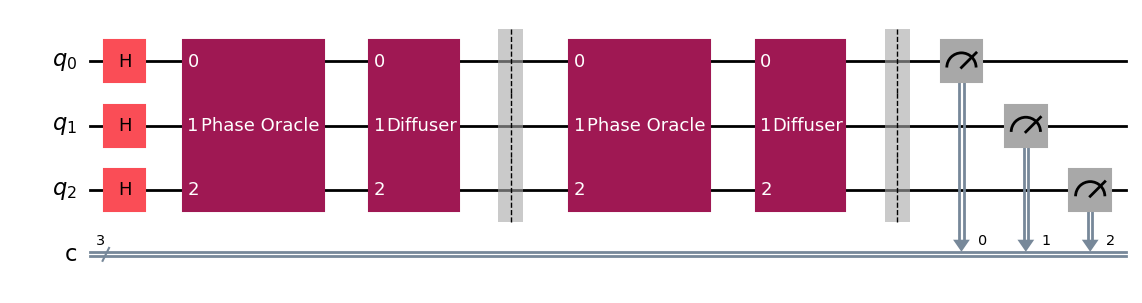

In [11]:
n = 3
N = 2**n 
M = 1

sat_qc = QuantumCircuit(n,n) #n qubits and n-bit classical measurement register

DIMACS_CNF = "(x1 | ~x2 | x3) & (~x1 | x2 | x3)" #Dimacs format of SAT expression

def iter(N,M):
    return math.floor((math.pi/4) * math.sqrt(N/M))

sat_qc.h(range(n)) #create superposition of 2**n = N states

diff_circ = GroverDiffuser(n) #reuse the same diffuser
oracle_circ = PhaseOracle(DIMACS_CNF)

for i in range(iter(N,M)):
    sat_qc.append(oracle_circ, range(n))
    sat_qc.append(diff_circ, range(n))
    sat_qc.barrier(range(n))

sat_qc.measure(range(n),range(n))

sat_qc.draw('mpl')


{'101': 4126, '011': 4048, '111': 4120, '110': 4058, '000': 4158, '010': 4020, '100': 4106, '001': 4132}


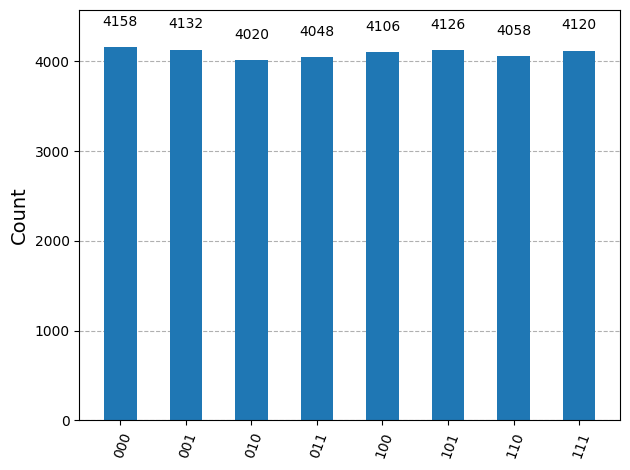

In [12]:
shots = 4096*8

backend = AerSimulator()

transpiled_sat_qc = transpile(sat_qc,backend)

job = backend.run(transpiled_sat_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_sat_qc)

print(counts)

plot_histogram(counts)

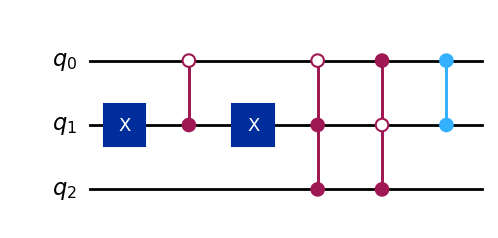

In [13]:
oracle_circ.draw('mpl') #oracle circuit gate figure


Limitation of Grovers algorithm. Since $n=3$ is small, from hand calculations we can see that number of solutions M = 6. Since M is not very small compared to N, the number of optimal iterations at M = 6 beomes 0, showing that we are effectively measuring equal superpositions. Grover's Alogirthm not very useful here. 

Attempt to do many runs and tabulate most occuring cases, didnt work out very well:

Reason: There is no real 'magnification' of probabilites in this case since number of solutions $M$ is very close to $N$.

In [14]:
solutions_data = {'001': 0, '010': 0, '101': 0, '000': 0, '011': 0, '110': 0, '100': 0, '111': 0}

for i in range(1000):
    job = backend.run(transpiled_sat_qc,shots = shots)

    result = job.result()

    counts = result.get_counts(transpiled_sat_qc)

    solutions_data[max(counts,key=counts.get)] += 1

print(solutions_data)
    

{'001': 114, '010': 142, '101': 118, '000': 112, '011': 110, '110': 134, '100': 134, '111': 136}


The above algorithm can be easily generalised as follows:

Lets make a 5 variable (and hence 5 qubit) boolean expression as:

$$f(x_1,x_2,x_3,x_4,x_5) = (x_1 \lor x_2 \lor x_3) \land (x_1 \lor \lnot x_2 \lor \lnot x_3) \land (\lnot x_1 \lor x_2 \lor \lnot x_4) \land (x_4 \lor x_5 \lor \lnot x_3) \land (\lnot x_1 \lor \lnot x_4 \lor \lnot x_5)$$

looking at the expression we can see that the number of solutions is $15$ out of total $2^5 = 32$ solutions. Lets implement this for varying values of M.

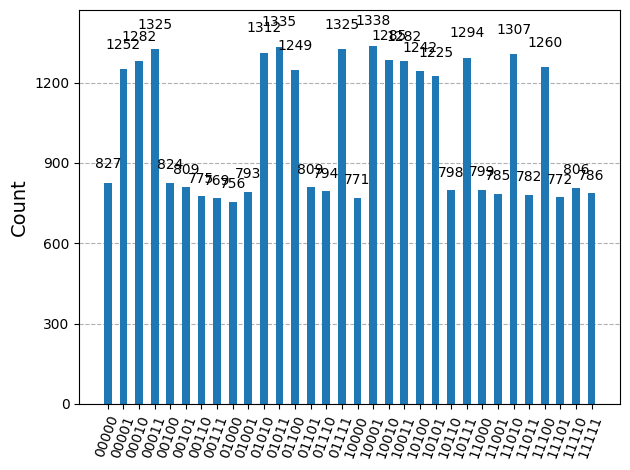

In [15]:
del sat_qc

n = 5
N = 2**n 
M = 15
sat_qc = QuantumCircuit(n,n) #n qubits and n-bit classical measurement register

DIMACS_CNF = "(x1 | x2 | x3) & (x1 | ~x2 | ~x3) & (~x1 | x2 | ~x4) & (x4 | x5 | ~x3) & (~x1 | ~x4 | ~x5)" #Dimacs format of SAT expression

sat_qc.h(range(n)) #create superposition of 2**n = N states

diff_circ = GroverDiffuser(n) #reuse the same diffuser function
oracle_circ = PhaseOracle(DIMACS_CNF)

for i in range(iter(N,M)): #iter(N,M) is 1 for condition
    sat_qc.append(oracle_circ, range(n))
    sat_qc.append(diff_circ, range(n))
    sat_qc.barrier(range(n))

sat_qc.measure(range(n),range(n))

shots = 4096*8

backend = AerSimulator()

transpiled_sat_qc = transpile(sat_qc,backend)

job = backend.run(transpiled_sat_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_sat_qc)

sat_qc.draw('mpl')

plot_histogram(counts)


We can see that Grovers algorithm perfectly gives out the 15 solutions with a distinct high probability. Yayy

Lets now see the effect of $M$ on the probability distribution histogram. We can see that the value of M only affects the value $r$ (number of iterations), so we can see the results of iterations = 0,1,2,3,4 respectively and this will capture the full picture from $M = 1$ to $M=N=32$.

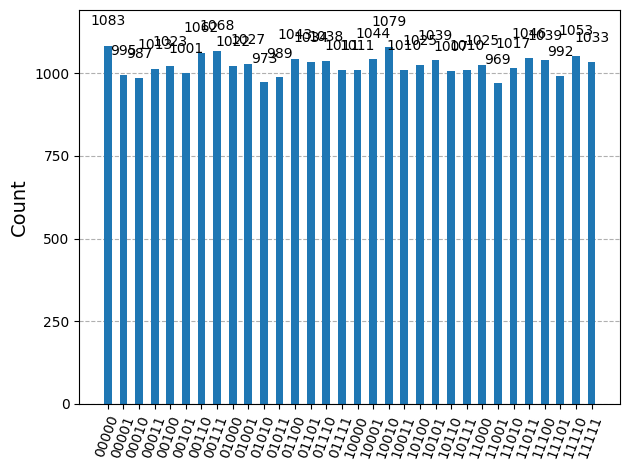

In [16]:
#iter = 0 case

del sat_qc

sat_qc = QuantumCircuit(n,n) #n qubits and n-bit classical measurement register

DIMACS_CNF = "(x1 | x2 | x3) & (x1 | ~x2 | ~x3) & (~x1 | x2 | ~x4) & (x4 | x5 | ~x3) & (~x1 | ~x4 | ~x5)" #Dimacs format of SAT expression

sat_qc.h(range(n)) #create superposition of 2**n = N states

diff_circ = GroverDiffuser(n) #reuse the same diffuser function
oracle_circ = PhaseOracle(DIMACS_CNF)

for i in range(0): #iter(N,M) is 1 for condition
    sat_qc.append(oracle_circ, range(n))
    sat_qc.append(diff_circ, range(n))
    sat_qc.barrier(range(n))

sat_qc.measure(range(n),range(n))

shots = 4096*8

backend = AerSimulator()

transpiled_sat_qc = transpile(sat_qc,backend)

job = backend.run(transpiled_sat_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_sat_qc)

sat_qc.draw('mpl')

plot_histogram(counts)



As we suspected, this is a flat graph of equal probabilities since there is no amplification of probabilities.

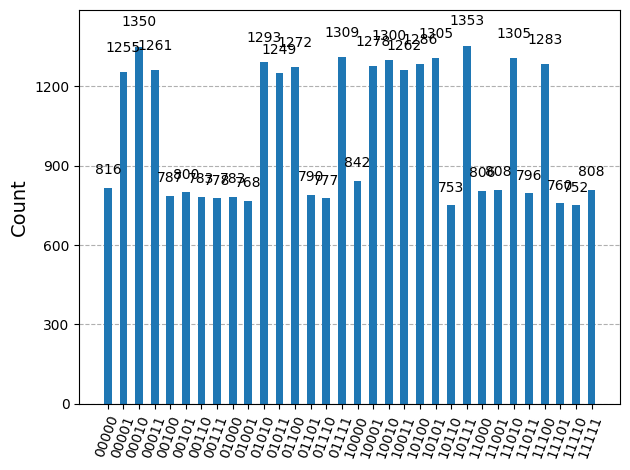

In [17]:
#iter = 1 case

del sat_qc

sat_qc = QuantumCircuit(n,n) #n qubits and n-bit classical measurement register

DIMACS_CNF = "(x1 | x2 | x3) & (x1 | ~x2 | ~x3) & (~x1 | x2 | ~x4) & (x4 | x5 | ~x3) & (~x1 | ~x4 | ~x5)" #Dimacs format of SAT expression

sat_qc.h(range(n)) #create superposition of 2**n = N states

diff_circ = GroverDiffuser(n) #reuse the same diffuser function
oracle_circ = PhaseOracle(DIMACS_CNF)

for i in range(1): #iter(N,M) is 1 for condition
    sat_qc.append(oracle_circ, range(n))
    sat_qc.append(diff_circ, range(n))
    sat_qc.barrier(range(n))

sat_qc.measure(range(n),range(n))

shots = 4096*8

backend = AerSimulator()

transpiled_sat_qc = transpile(sat_qc,backend)

job = backend.run(transpiled_sat_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_sat_qc)

sat_qc.draw('mpl')

plot_histogram(counts)



This is our previous example where there is perfect amplification of 15 solutions

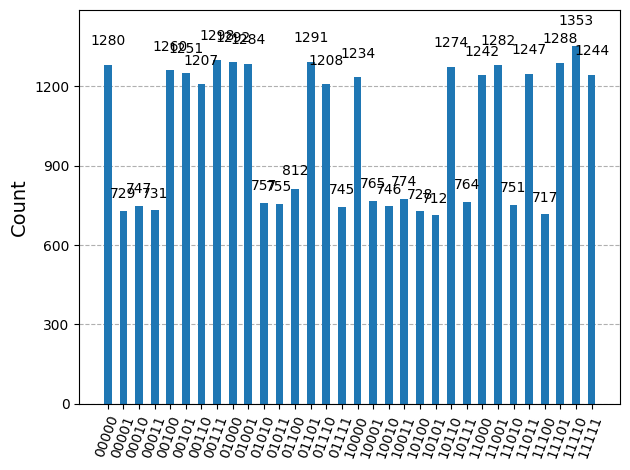

In [18]:
#iter = 2 case

del sat_qc

sat_qc = QuantumCircuit(n,n) #n qubits and n-bit classical measurement register

DIMACS_CNF = "(x1 | x2 | x3) & (x1 | ~x2 | ~x3) & (~x1 | x2 | ~x4) & (x4 | x5 | ~x3) & (~x1 | ~x4 | ~x5)" #Dimacs format of SAT expression

sat_qc.h(range(n)) #create superposition of 2**n = N states

diff_circ = GroverDiffuser(n) #reuse the same diffuser function
oracle_circ = PhaseOracle(DIMACS_CNF)

for i in range(2): #iter(N,M) is 1 for condition
    sat_qc.append(oracle_circ, range(n))
    sat_qc.append(diff_circ, range(n))
    sat_qc.barrier(range(n))

sat_qc.measure(range(n),range(n))

shots = 4096*8

backend = AerSimulator()

transpiled_sat_qc = transpile(sat_qc,backend)

job = backend.run(transpiled_sat_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_sat_qc)

sat_qc.draw('mpl')

plot_histogram(counts)


This is **EXTREMELY** interesting. We see that by applying 2 iterations, we have effectively *anti-amplified* the correct solutions and now ALL the incorrect solutions have greater probability of measurement. This clearly shows how we have passed the optimal number of iterations of iter = 1. 

This happens when the average amplitude $\mu$, after the oracle $O_f^\pm$ has acted, becomes negative $\mu < 0$, meaning when the diffuser acts, the amplitudes of the function solutions decreases.

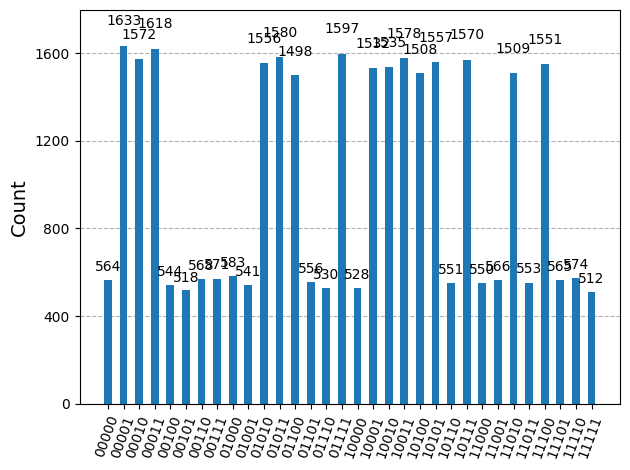

In [19]:
#iter = 3 case

del sat_qc

sat_qc = QuantumCircuit(n,n) #n qubits and n-bit classical measurement register

DIMACS_CNF = "(x1 | x2 | x3) & (x1 | ~x2 | ~x3) & (~x1 | x2 | ~x4) & (x4 | x5 | ~x3) & (~x1 | ~x4 | ~x5)" #Dimacs format of SAT expression

sat_qc.h(range(n)) #create superposition of 2**n = N states

diff_circ = GroverDiffuser(n) #reuse the same diffuser function
oracle_circ = PhaseOracle(DIMACS_CNF)

for i in range(3): #iter(N,M) is 1 for condition
    sat_qc.append(oracle_circ, range(n))
    sat_qc.append(diff_circ, range(n))
    sat_qc.barrier(range(n))

sat_qc.measure(range(n),range(n))

shots = 4096*8

backend = AerSimulator()

transpiled_sat_qc = transpile(sat_qc,backend)

job = backend.run(transpiled_sat_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_sat_qc)

sat_qc.draw('mpl')

plot_histogram(counts)

Now again, applying another iteration will re-amplify the previously "anti-amplified" solutions to give correct 15 sets of solutions. 

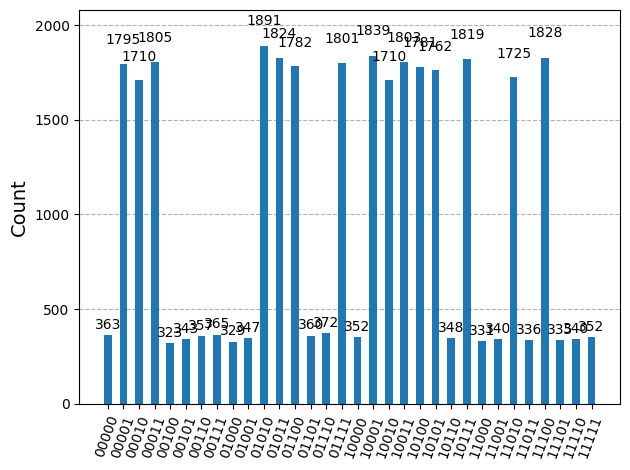

In [20]:
#iter = 5 case

del sat_qc

sat_qc = QuantumCircuit(n,n) #n qubits and n-bit classical measurement register

DIMACS_CNF = "(x1 | x2 | x3) & (x1 | ~x2 | ~x3) & (~x1 | x2 | ~x4) & (x4 | x5 | ~x3) & (~x1 | ~x4 | ~x5)" #Dimacs format of SAT expression

sat_qc.h(range(n)) #create superposition of 2**n = N states

diff_circ = GroverDiffuser(n) #reuse the same diffuser function
oracle_circ = PhaseOracle(DIMACS_CNF)

for i in range(5):
    sat_qc.append(oracle_circ, range(n))
    sat_qc.append(diff_circ, range(n))
    sat_qc.barrier(range(n))

sat_qc.measure(range(n),range(n))

shots = 4096*8

backend = AerSimulator()

transpiled_sat_qc = transpile(sat_qc,backend)

job = backend.run(transpiled_sat_qc,shots = shots)

result = job.result()

counts = result.get_counts(transpiled_sat_qc)

sat_qc.draw('mpl')

plot_histogram(counts)


For this condition, we see very strong amplification of the 15 solutions. 